In [3]:
!pip install transformers datasets torch torchvision scikit-learn pandas numpy matplotlib seaborn wordcloud nltk streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW # Changed to import AdamW from torch.optim
from datasets import load_dataset

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab') # Added to fix the LookupError

print(" All libraries installed and imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


 All libraries installed and imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


In [5]:
print("\n" + "="*80)
print("LOADING IMDB DATASET")
print("="*80)

# Load IMDB dataset from Hugging Face
dataset = load_dataset('imdb')

# Convert to pandas for easier manipulation
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

print(f"\n Dataset loaded successfully!")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

# Display first few samples
print("\n" + "-"*80)
print("SAMPLE REVIEWS:")
print("-"*80)
print(train_df.head())

# Basic statistics
print("\n" + "-"*80)
print("DATASET STATISTICS:")
print("-"*80)
print(train_df.info())
print("\nClass Distribution:")
print(train_df['label'].value_counts())

# For faster experimentation, let's use a subset
# Comment these lines if you want to use full dataset
SAMPLE_SIZE = 10000
train_df = train_df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
test_df = test_df.sample(n=int(SAMPLE_SIZE*0.3), random_state=42).reset_index(drop=True)

print(f"\n Using subset for faster training:")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")


LOADING IMDB DATASET


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]


 Dataset loaded successfully!
Training samples: 25000
Testing samples: 25000

--------------------------------------------------------------------------------
SAMPLE REVIEWS:
--------------------------------------------------------------------------------
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0

--------------------------------------------------------------------------------
DATASET STATISTICS:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 n


EXPLORATORY DATA ANALYSIS


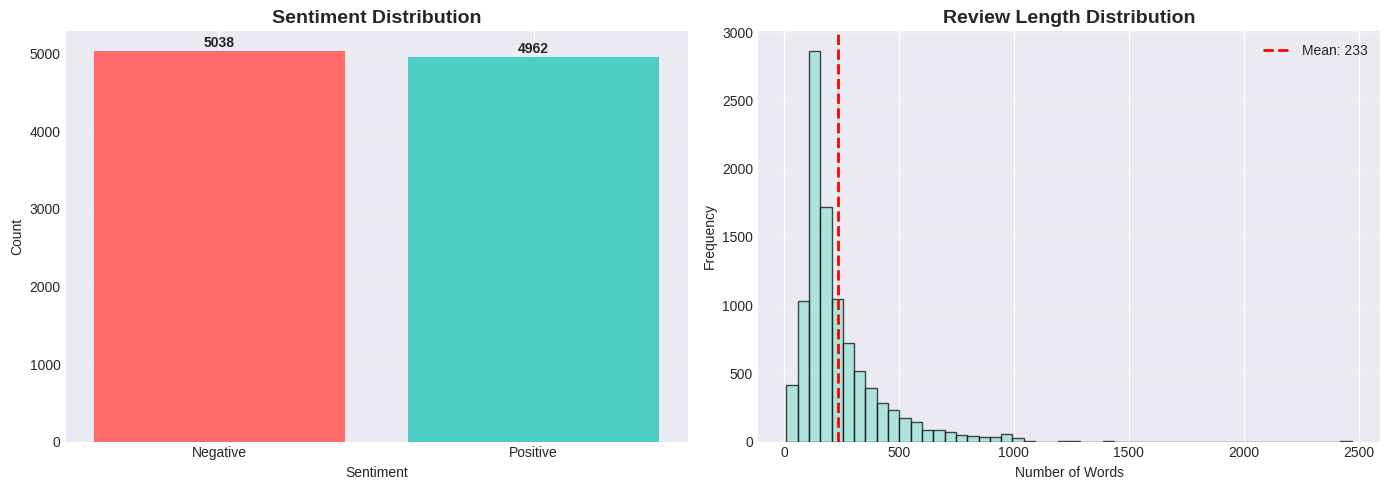


--------------------------------------------------------------------------------
REVIEW LENGTH STATISTICS BY SENTIMENT:
--------------------------------------------------------------------------------
            count        mean         std   min    25%    50%     75%     max
sentiment                                                                    
Negative   5038.0  230.290393  165.862923  10.0  128.0  174.0  275.75  1021.0
Positive   4962.0  235.192664  178.690768  17.0  125.0  173.0  291.00  2470.0


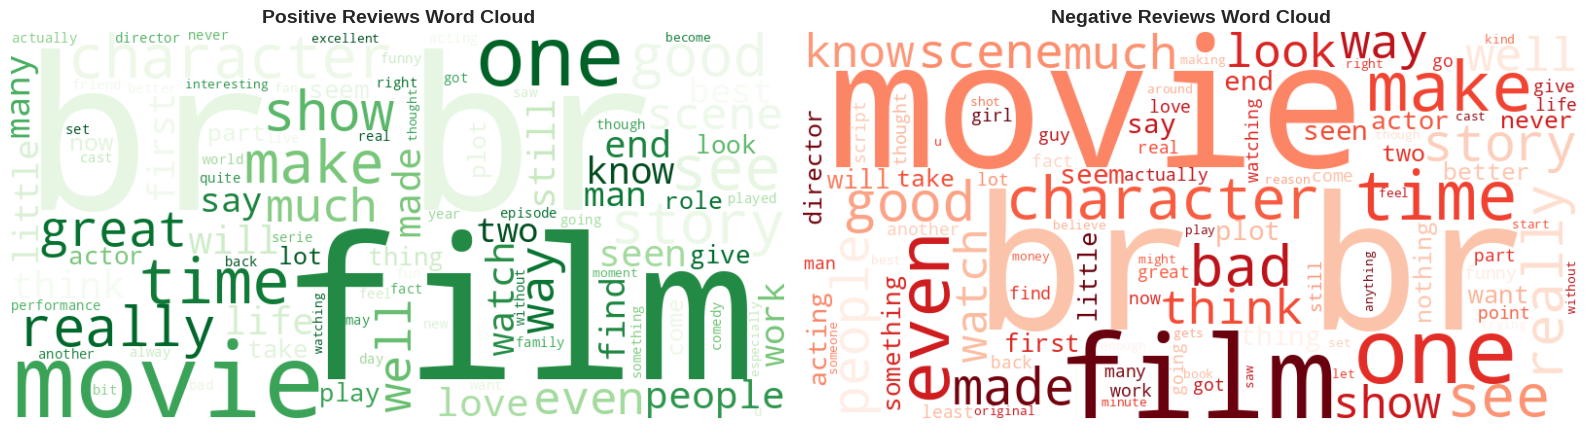

In [6]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Set up visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Sentiment Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_df['sentiment'] = train_df['label'].map({0: 'Negative', 1: 'Positive'})
sentiment_counts = train_df['sentiment'].value_counts()

axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=['#ff6b6b', '#4ecdc4'])
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(sentiment_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# 2. Review Length Distribution
train_df['review_length'] = train_df['text'].apply(lambda x: len(x.split()))

axes[1].hist(train_df['review_length'], bins=50, color='#95e1d3', edgecolor='black', alpha=0.7)
axes[1].axvline(train_df['review_length'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {train_df["review_length"].mean():.0f}')
axes[1].set_title('Review Length Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Statistics by sentiment
print("\n" + "-"*80)
print("REVIEW LENGTH STATISTICS BY SENTIMENT:")
print("-"*80)
print(train_df.groupby('sentiment')['review_length'].describe())

# 4. Word Clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, sentiment in enumerate(['Positive', 'Negative']):
    text = ' '.join(train_df[train_df['sentiment'] == sentiment]['text'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         colormap='Greens' if sentiment == 'Positive' else 'Reds',
                         max_words=100).generate(text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{sentiment} Reviews Word Cloud', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [7]:
print("\n" + "="*80)
print("TEXT PREPROCESSING")
print("="*80)

class TextPreprocessor:
    """
    Comprehensive text preprocessing for sentiment analysis
    """
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Keep some sentiment-bearing stopwords
        self.stop_words -= {'not', 'no', 'nor', 'never', 'neither', 'nobody',
                           'nothing', 'nowhere', 'but', 'however', 'very', 'too'}

    def clean_text(self, text):
        """Basic cleaning"""
        # Lowercase
        text = text.lower()
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove URLs
        text = re.sub(r'http\S+|www\S+', '', text)
        # Remove special characters and digits (keep basic punctuation)
        text = re.sub(r'[^a-zA-Z\s!?.]', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text

    def preprocess(self, text):
        """Complete preprocessing pipeline"""
        # Clean
        text = self.clean_text(text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens
                 if word not in self.stop_words and len(word) > 2]
        return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Show preprocessing example
print("\n" + "-"*80)
print("PREPROCESSING EXAMPLE:")
print("-"*80)
sample_review = train_df['text'].iloc[0]
print("ORIGINAL:")
print(sample_review[:500])
print("\n" + "-"*40)
print("PREPROCESSED:")
preprocessed = preprocessor.preprocess(sample_review)
print(preprocessed[:500])

# Apply preprocessing
print("\n Preprocessing all reviews...")
train_df['cleaned_text'] = train_df['text'].apply(preprocessor.preprocess)
test_df['cleaned_text'] = test_df['text'].apply(preprocessor.preprocess)
print(" Preprocessing complete!")

# Save a copy for later use
train_df['original_text'] = train_df['text']
test_df['original_text'] = test_df['text']



TEXT PREPROCESSING

--------------------------------------------------------------------------------
PREPROCESSING EXAMPLE:
--------------------------------------------------------------------------------
ORIGINAL:
Dumb is as dumb does, in this thoroughly uninteresting, supposed black comedy. Essentially what starts out as Chris Klein trying to maintain a low profile, eventually morphs into an uninspired version of "The Three Amigos", only without any laughs. In order for black comedy to work, it must be outrageous, which "Play Dead" is not. In order for black comedy to work, it cannot be mean spirited, which "Play Dead" is. What "Play Dead" really is, is a town full of nut jobs. Fred Dunst does however do

----------------------------------------
PREPROCESSED:
dumb dumb thoroughly uninteresting supposed black comedy essentially start chris klein trying maintain low profile eventually morphs uninspired version three amigo without laugh order black comedy work must outrageous play dead


APPROACH 1: TF-IDF + LOGISTIC REGRESSION

 Creating TF-IDF features...
 TF-IDF features created!
Feature matrix shape: (10000, 5000)
Vocabulary size: 5000

 Training Logistic Regression model...
 Model trained!

--------------------------------------------------------------------------------
TRADITIONAL ML MODEL RESULTS:
--------------------------------------------------------------------------------

Accuracy: 0.8707

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87      1555
    Positive       0.86      0.88      0.87      1445

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



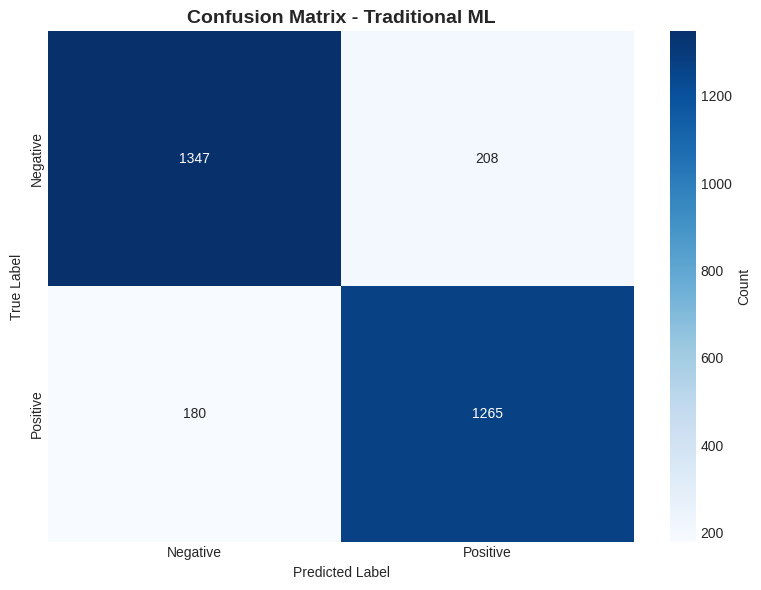

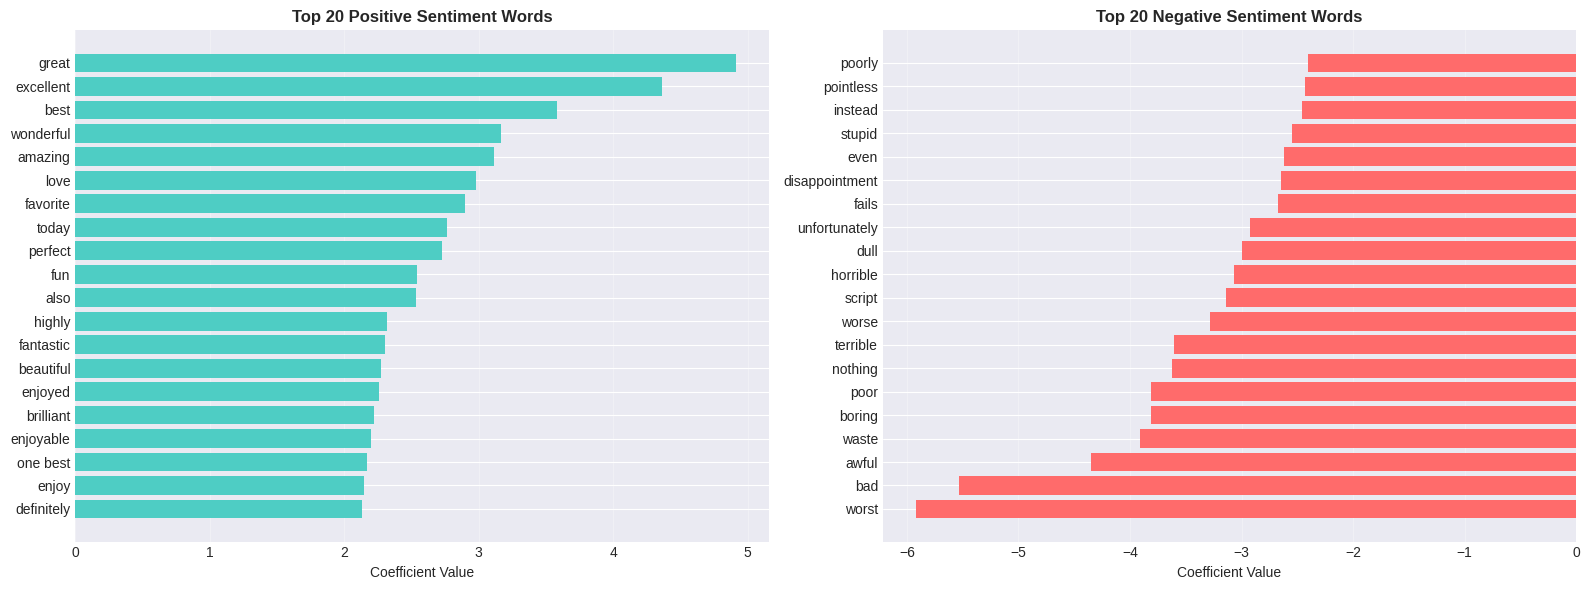

In [8]:
print("\n" + "="*80)
print("APPROACH 1: TF-IDF + LOGISTIC REGRESSION")
print("="*80)

# Prepare data
X_train_text = train_df['cleaned_text']
y_train = train_df['label']
X_test_text = test_df['cleaned_text']
y_test = test_df['label']

# TF-IDF Vectorization
print("\n Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,
    max_df=0.8
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f" TF-IDF features created!")
print(f"Feature matrix shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Train Logistic Regression
print("\n Training Logistic Regression model...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    C=1.0,
    solver='liblinear'
)
lr_model.fit(X_train_tfidf, y_train)
print(" Model trained!")

# Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

# Evaluation
print("\n" + "-"*80)
print("TRADITIONAL ML MODEL RESULTS:")
print("-"*80)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr,
                          target_names=['Negative', 'Positive']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Traditional ML', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Feature Importance (Top positive and negative words)
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Top 20 positive and negative features
top_positive_idx = np.argsort(coefficients)[-20:]
top_negative_idx = np.argsort(coefficients)[:20]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive features
axes[0].barh(range(20), coefficients[top_positive_idx], color='#4ecdc4')
axes[0].set_yticks(range(20))
axes[0].set_yticklabels([feature_names[i] for i in top_positive_idx])
axes[0].set_title('Top 20 Positive Sentiment Words', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Coefficient Value')
axes[0].grid(axis='x', alpha=0.3)

# Negative features
axes[1].barh(range(20), coefficients[top_negative_idx], color='#ff6b6b')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels([feature_names[i] for i in top_negative_idx])
axes[1].set_title('Top 20 Negative Sentiment Words', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Coefficient Value')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()



APPROACH 2: LSTM NEURAL NETWORK
TensorFlow version: 2.19.0

 Tokenizing text for LSTM...
 Tokenization complete!
Vocabulary size: 59088
Padded sequence shape: (10000, 200)

 Building LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

 Training LSTM model...
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.5556 - loss: 0.6761 - val_accuracy: 0.8090 - val_loss: 0.4359 - learning_rate: 0.0010
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8759 - loss: 0.3412 - val_accuracy: 0.8435 - val_loss: 0.3870 - learning_rate: 0.0010
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9402 - loss: 0.1865 - val_accuracy: 0.8375 - val_loss: 0.4749 - learning_rate: 0.0010
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9708 - loss: 0.0981 - val_accuracy: 0.8355 - val_loss: 0.5669 - learning_rate: 0.0010
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9910 - loss: 0.0393 - val_accuracy: 0.8330 - val_loss: 0.7170 - learning_rate: 5.0000e-04
 LSTM model trained!

--------------------------------------------------------------------------------
LSTM MODEL RESULTS:
-----------------------------------------------------------------------------

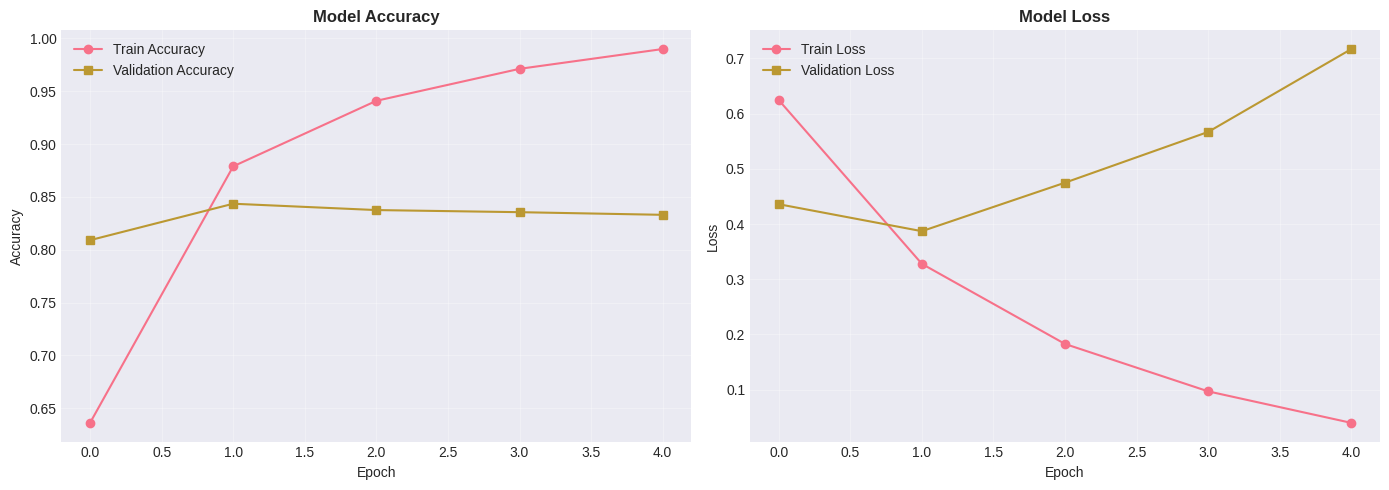

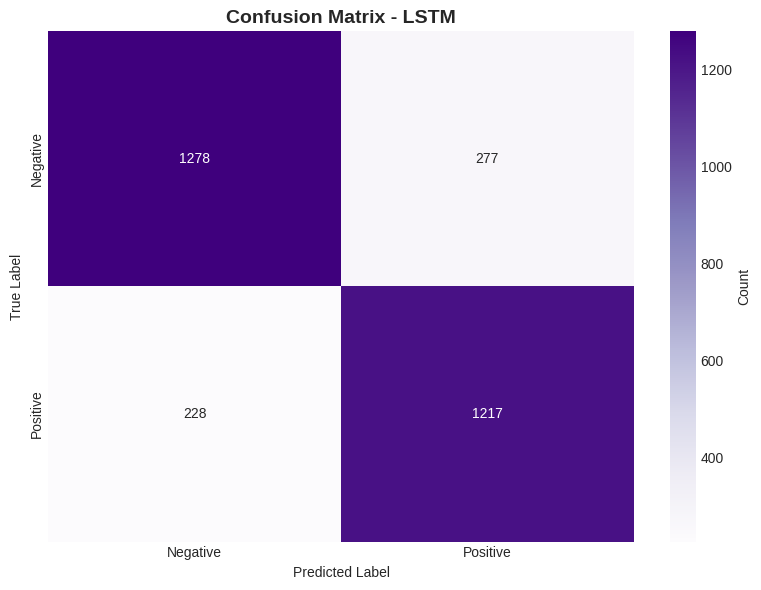

In [9]:
print("\n" + "="*80)
print("APPROACH 2: LSTM NEURAL NETWORK")
print("="*80)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Install TensorFlow if needed
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except:
    !pip install tensorflow -q
    import tensorflow as tf

# Tokenization for LSTM
print("\n Tokenizing text for LSTM...")
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_text'])

X_train_seq = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['cleaned_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(f" Tokenization complete!")
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Padded sequence shape: {X_train_pad.shape}")

# Build LSTM Model
print("\n Building LSTM model...")
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(lstm_model.summary())

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)

# Train LSTM
print("\n Training LSTM model...")
history = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(" LSTM model trained!")

# Evaluate LSTM
print("\n" + "-"*80)
print("LSTM MODEL RESULTS:")
print("-"*80)

y_pred_lstm_proba = lstm_model.predict(X_test_pad).flatten()
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_lstm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm,
                          target_names=['Negative', 'Positive']))

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion Matrix for LSTM
plt.figure(figsize=(8, 6))
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LSTM', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


APPROACH 3: BERT (Fine-tuning Pre-trained Transformer)

  Note: BERT training requires significant computational resources.
This section uses a smaller subset and fewer epochs for demonstration.

  Using device: cuda

 BERT training samples: 1000
 BERT testing samples: 300

 Loading BERT model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Fine-tuning BERT for 2 epochs...
Epoch 1/2 | Batch 10/63 | Loss: 0.7102
Epoch 1/2 | Batch 20/63 | Loss: 0.6364
Epoch 1/2 | Batch 30/63 | Loss: 0.6100
Epoch 1/2 | Batch 40/63 | Loss: 0.5814
Epoch 1/2 | Batch 50/63 | Loss: 0.4115
Epoch 1/2 | Batch 60/63 | Loss: 0.5469

 Epoch 1 completed | Average Loss: 0.6173

Epoch 2/2 | Batch 10/63 | Loss: 0.3361
Epoch 2/2 | Batch 20/63 | Loss: 0.2725
Epoch 2/2 | Batch 30/63 | Loss: 0.3751
Epoch 2/2 | Batch 40/63 | Loss: 0.3938
Epoch 2/2 | Batch 50/63 | Loss: 0.3764
Epoch 2/2 | Batch 60/63 | Loss: 0.1928

 Epoch 2 completed | Average Loss: 0.3776

 BERT fine-tuning complete!

 Evaluating BERT model...

--------------------------------------------------------------------------------
BERT MODEL RESULTS:
--------------------------------------------------------------------------------

Accuracy: 0.8433

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.77      0.83       149
    Positive       0

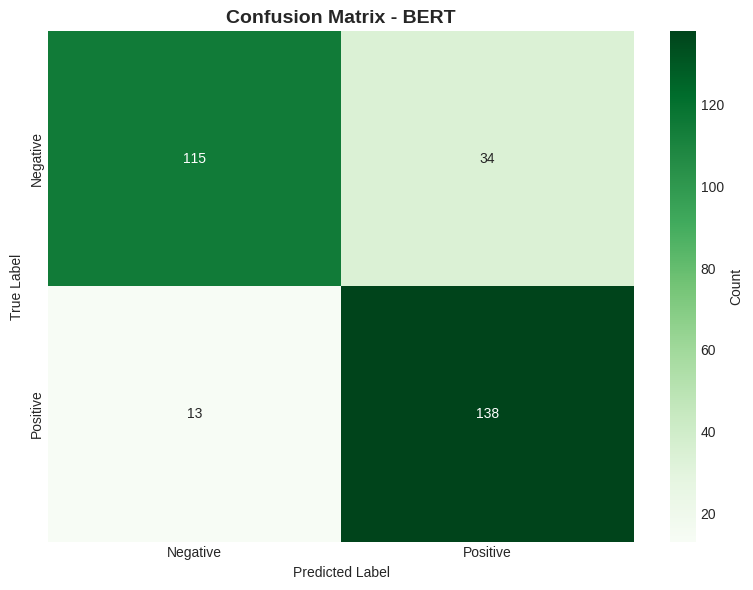

In [10]:
print("\n" + "="*80)
print("APPROACH 3: BERT (Fine-tuning Pre-trained Transformer)")
print("="*80)
print("\n  Note: BERT training requires significant computational resources.")
print("This section uses a smaller subset and fewer epochs for demonstration.")

# For Colab, check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n  Using device: {device}")

# Use even smaller subset for BERT demo
BERT_SAMPLE_SIZE = 1000
train_bert_df = train_df.sample(n=BERT_SAMPLE_SIZE, random_state=42)
test_bert_df = test_df.sample(n=int(BERT_SAMPLE_SIZE*0.3), random_state=42)

print(f"\n BERT training samples: {len(train_bert_df)}")
print(f" BERT testing samples: {len(test_bert_df)}")

# Load BERT tokenizer and model
print("\n Loading BERT model...")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
).to(device)

# Custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and dataloaders
train_dataset = SentimentDataset(
    train_bert_df['original_text'].values,
    train_bert_df['label'].values,
    bert_tokenizer
)

test_dataset = SentimentDataset(
    test_bert_df['original_text'].values,
    test_bert_df['label'].values,
    bert_tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training setup
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
epochs = 2  # Reduced for demo purposes

print(f"\n Fine-tuning BERT for {epochs} epochs...")

# Training loop
bert_model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"\n Epoch {epoch+1} completed | Average Loss: {avg_loss:.4f}\n")

print(" BERT fine-tuning complete!")

# Evaluate BERT
print("\n Evaluating BERT model...")
bert_model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        predictions = torch.argmax(outputs.logits, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# BERT Results
print("\n" + "-"*80)
print("BERT MODEL RESULTS:")
print("-"*80)
print(f"\nAccuracy: {accuracy_score(all_labels, all_predictions):.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions,
                          target_names=['Negative', 'Positive']))

# Confusion Matrix for BERT
plt.figure(figsize=(8, 6))
cm_bert = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - BERT', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()



MODEL COMPARISON

--------------------------------------------------------------------------------
PERFORMANCE METRICS:
--------------------------------------------------------------------------------
                        Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression\n(TF-IDF)  0.870667   0.858792 0.875433  0.867032
                         LSTM  0.831667   0.814592 0.842215  0.828173
                         BERT  0.843333   0.802326 0.913907  0.854489


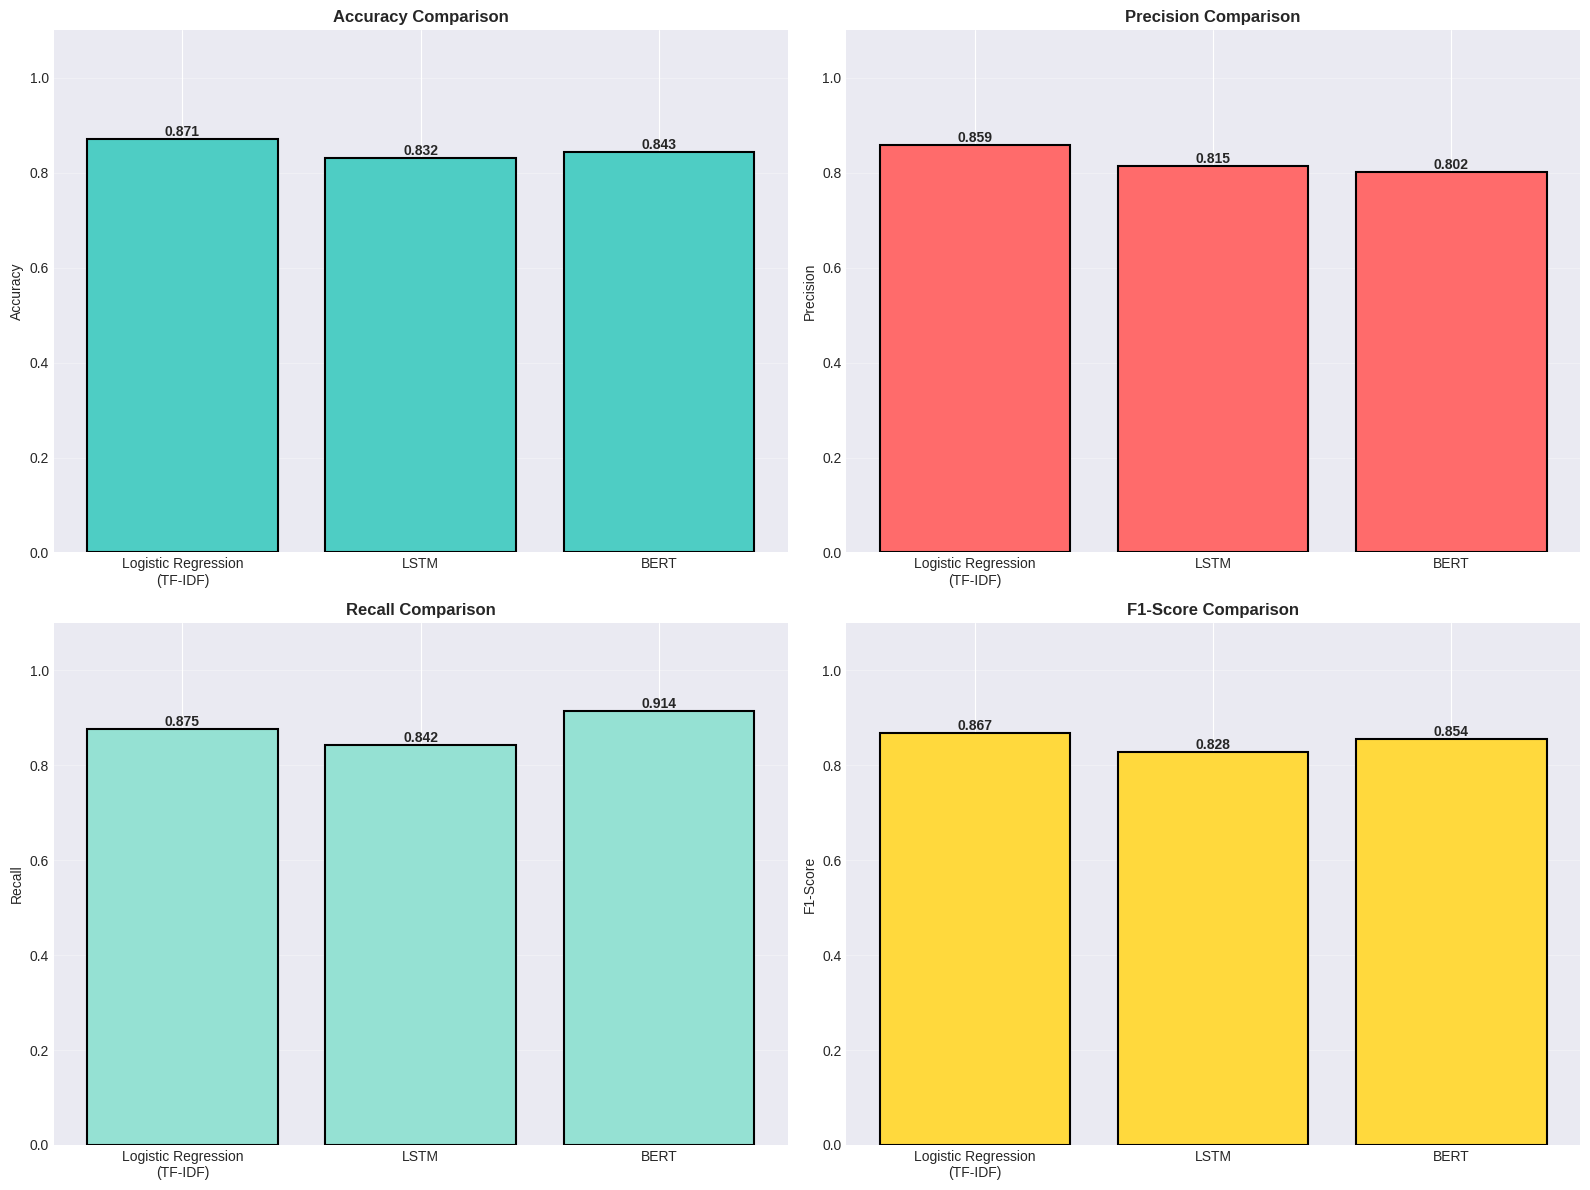

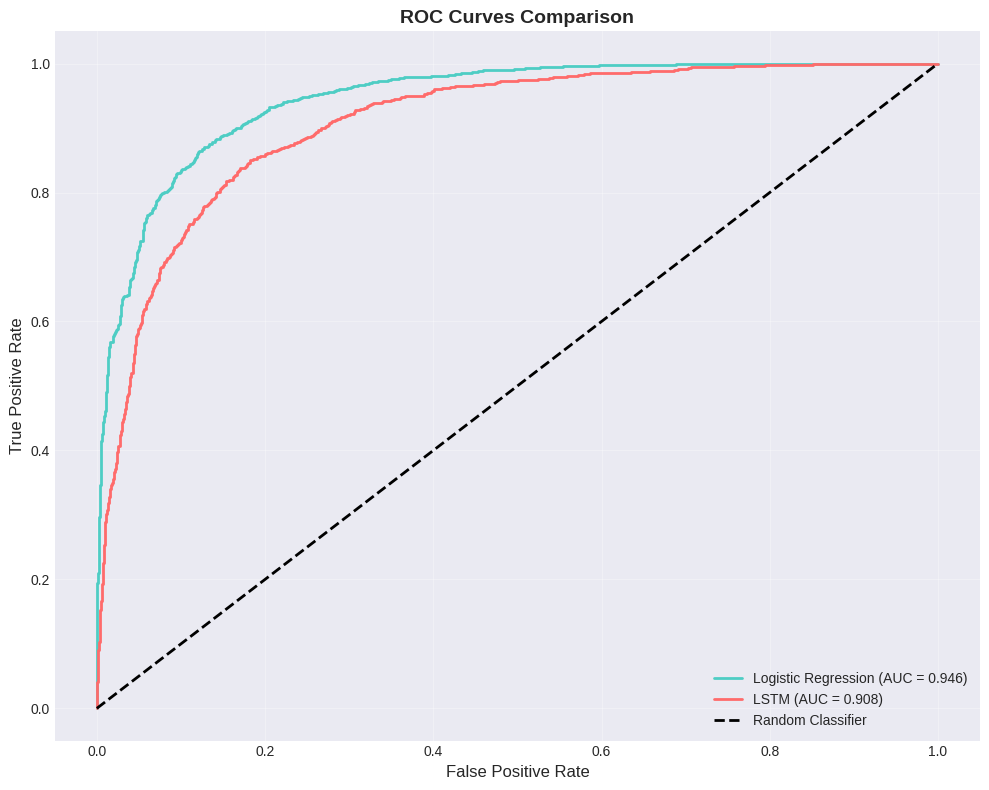

In [11]:
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# Calculate metrics for all models
from sklearn.metrics import precision_score, recall_score, f1_score

models_comparison = {
    'Model': ['Logistic Regression\n(TF-IDF)', 'LSTM', 'BERT'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_lstm),
        accuracy_score(all_labels, all_predictions)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_lstm),
        precision_score(all_labels, all_predictions)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_lstm),
        recall_score(all_labels, all_predictions)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lstm),
        f1_score(all_labels, all_predictions)
    ]
}

comparison_df = pd.DataFrame(models_comparison)
print("\n" + "-"*80)
print("PERFORMANCE METRICS:")
print("-"*80)
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#4ecdc4', '#ff6b6b', '#95e1d3', '#ffd93d']

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2

    bars = axes[row, col].bar(comparison_df['Model'],
                               comparison_df[metric],
                               color=colors[idx],
                               edgecolor='black',
                               linewidth=1.5)
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel(metric)
    axes[row, col].set_ylim([0, 1.1])
    axes[row, col].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.3f}',
                           ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ROC Curves Comparison
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})',
         linewidth=2, color='#4ecdc4')

# LSTM ROC
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm_proba)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {roc_auc_lstm:.3f})',
         linewidth=2, color='#ff6b6b')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [14]:
print("\n" + "="*80)
print("LIVE PREDICTIONS ON NEW REVIEWS")
print("="*80)

def predict_sentiment_lr(text):
    """Predict using Logistic Regression"""
    cleaned = preprocessor.preprocess(text)
    features = tfidf_vectorizer.transform([cleaned])
    prediction = lr_model.predict(features)[0]
    probability = lr_model.predict_proba(features)[0]
    return prediction, probability

def predict_sentiment_lstm(text):
    """Predict using LSTM"""
    cleaned = preprocessor.preprocess(text)
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    probability = lstm_model.predict(padded, verbose=0)[0][0]
    prediction = 1 if probability > 0.5 else 0
    return prediction, [1-probability, probability]

# Test reviews
test_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.",
    "Terrible waste of time. Poor acting, weak storyline, and terrible special effects.",
    "It was okay, nothing special but not terrible either. Average movie.",
    "I loved every minute of it! Best film I've seen this year. Highly recommend!",
    "Boring and predictable. I fell asleep halfway through."
]

print("\n" + "-"*80)
print("PREDICTIONS:")
print("-"*80)

results_data = []

for i, review in enumerate(test_reviews, 1):
    print(f"\n{'='*80}")
    print(f"Review {i}:")
    print(f"{'='*80}")
    print(f"{review}\n")

    # Logistic Regression
    pred_lr, prob_lr = predict_sentiment_lr(review)
    sentiment_lr = "Positive" if pred_lr == 1 else "Negative"
    confidence_lr = prob_lr[pred_lr] * 100

    # LSTM
    pred_lstm, prob_lstm = predict_sentiment_lstm(review)
    sentiment_lstm = "Positive" if pred_lstm == 1 else "Negative"
    confidence_lstm = prob_lstm[pred_lstm] * 100

    print(f" Logistic Regression: {sentiment_lr} (Confidence: {confidence_lr:.1f}%)")
    print(f" LSTM: {sentiment_lstm} (Confidence: {confidence_lstm:.1f}%)")

    results_data.append({
        'Review': review[:50] + '...',
        'LR Prediction': sentiment_lr,
        'LR Confidence': f"{confidence_lr:.1f}%",
        'LSTM Prediction': sentiment_lstm,
        'LSTM Confidence': f"{confidence_lstm:.1f}%"
    })

# Display results table
results_df = pd.DataFrame(results_data)
print("\n" + "="*80)
print("SUMMARY TABLE:")
print("="*80)
print(results_df.to_string(index=False))




LIVE PREDICTIONS ON NEW REVIEWS

--------------------------------------------------------------------------------
PREDICTIONS:
--------------------------------------------------------------------------------

Review 1:
This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.

 Logistic Regression: Positive (Confidence: 76.0%)
 LSTM: Positive (Confidence: 85.9%)

Review 2:
Terrible waste of time. Poor acting, weak storyline, and terrible special effects.

 Logistic Regression: Negative (Confidence: 99.7%)
 LSTM: Negative (Confidence: 98.0%)

Review 3:
It was okay, nothing special but not terrible either. Average movie.

 Logistic Regression: Negative (Confidence: 97.8%)
 LSTM: Negative (Confidence: 85.5%)

Review 4:
I loved every minute of it! Best film I've seen this year. Highly recommend!

 Logistic Regression: Positive (Confidence: 95.1%)
 LSTM: Positive (Confidence: 92.3%)

Review 5:
Boring and predictable. I fell asleep halfway through.


In [15]:
print("\n" + "="*80)
print("SAVING MODELS")
print("="*80)

import pickle
import os

# Create models directory
os.makedirs('models', exist_ok=True)

# Save Traditional ML model and vectorizer
with open('models/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print(" Saved: logistic_regression_model.pkl")

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(" Saved: tfidf_vectorizer.pkl")

with open('models/text_preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print(" Saved: text_preprocessor.pkl")

# Save LSTM model
lstm_model.save('models/lstm_sentiment_model.h5')
print(" Saved: lstm_sentiment_model.h5")

with open('models/lstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print(" Saved: lstm_tokenizer.pkl")

# Save BERT model
bert_model.save_pretrained('models/bert_sentiment_model')
bert_tokenizer.save_pretrained('models/bert_sentiment_model')
print(" Saved: bert_sentiment_model/")

# Save comparison results
comparison_df.to_csv('models/model_comparison.csv', index=False)
print(" Saved: model_comparison.csv")

print("\n All models saved in 'models/' directory")



SAVING MODELS
 Saved: logistic_regression_model.pkl
 Saved: tfidf_vectorizer.pkl
 Saved: text_preprocessor.pkl
 Saved: lstm_sentiment_model.h5
 Saved: lstm_tokenizer.pkl
 Saved: bert_sentiment_model/
 Saved: model_comparison.csv

 All models saved in 'models/' directory
